In [1]:
import itertools
import os
import json

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from experience import load_experience
from bclassification.utils_base import (
    print_class_weights,
    compute_weight_bias,
    print_dataset,
    plot_metrics,
    plot_cm,
    plot_roc,
    describe_results,
)
from lib.constants import Constants as Const
from lib.data_utils import (
    make_dir,
    env_pf,
    create_results_dir,
    save_dict_to_file,
)
from lib.tf_utils import (
    print_variables,
    ResidulaFCBlock,
    MatthewsCorrelationCoefficient,
)
from lib.visualizer import Visualizer, pprint


experience_dir = make_dir(os.path.join(Const.EXPERIENCE_DIR, "data-aug"))
results_dir = make_dir(os.path.join(Const.RESULTS_DIR, "il"))

agent_name = "agent-mip"
case_name = "l2rpn_2019_art"
env_dc = True
verbose = False

case_results_dir = make_dir(os.path.join(results_dir, f"{case_name}-{env_pf(env_dc)}"))

In [2]:
"""
    Parameters
"""

random_seed = 0

input_mode = "structured"
label_mode = "dn"

n_window_targets = 12  # 0 or 12
n_window_history = 0
downsampling_rate = 0.10
n_window_forecasts = 1
use_actions = True
feature_scaling = True
batch_normalization = False

n_perturb = 0
scale_perturb = 0.02

val_frac = 0.10
test_frac = 0.10

# Model
model_type = "res"  # "fc" or "res"
dropout_rate = 0
l1_reg = 1e-7
l2_reg = 0
n_hidden = 512
n_hidden_layers = 4
threshold = 0.50
pos_scaling = 1

# Training
learning_rate = 1e-5
n_batch = 512
n_epochs = 250

In [3]:
def perturb(X, Y, scale, n):
    n_gen = 5
    n_load = 11
    n_line = 20
    n_sub = 14
    
    x_p = []
    y_p = []
    for _ in range(n):
        if input_mode == "binary":
            # Observation size
            s = 3 * n_gen + n_load + 2 * n_line + (4 * n_line + 2 * n_gen + 2 * n_load) + n_sub + 2 * n_line

            # Features to perturb
            n_first = 3 * n_gen + n_load + 2 * n_line  # Flows and injections

            x = X.copy()
            for h in range(n_window_history + 1):
                noise = np.random.normal(loc=0.0, scale=scale, size=(x.shape[0], n_first))
                x[:, h * s : (h * s + n_first)] = x[:, h * s : (h * s + n_first)] + noise

            # Forecast
            if n_window_forecasts > 0:
                n_last = n_window_forecasts * (n_gen + n_load)
                noise = np.random.normal(loc=0.0, scale=scale, size=(x.shape[0], n_last))
                x[:, -n_last:] = x[:, -n_last:] + noise

        elif input_mode == "structured":
            # Observation size
            s = 2 * (n_gen + n_load) + 2 * n_gen + 5 * n_line + n_sub + 2 * n_line

            # Features to perturb
            n_first = 2 * (n_gen + n_load) + 2 * n_gen + 5 * n_line  # Flows and injections

            x = X.copy()
            for h in range(n_window_history + 1):
                noise = np.random.normal(loc=0.0, scale=scale, size=(x.shape[0], n_first))
                x[:, h * s : (h * s + n_first)] = x[:, h * s : (h * s + n_first)] + noise

            # Forecasts
            if n_window_forecasts > 0:
                n_last = n_window_forecasts * (n_gen + n_load)
                noise = np.random.normal(loc=0.0, scale=scale, size=(x.shape[0], n_last))
                x[:, -n_last:] = x[:, -n_last:] + noise
        
        x_p.append(x)
        y_p.append(Y)
    
    return np.vstack(x_p), np.hstack(y_p)

In [4]:
%%capture cap --no-stderr
"""
    Dataset
"""

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

tar_str = f"w{n_window_targets}"
dr_str = str(int(100 * downsampling_rate))
f_str = str(n_window_forecasts)
h_str = str(n_window_history)

file_name = f"fc-d{dr_str}-h{h_str}-f{f_str}-{tar_str}-{input_mode}.npz"
file_path = os.path.join(experience_dir, file_name)

data = np.load(file_path)
X_all = data["X_all"]
Y_all = data["Y_all"]
mask_targets = data["mask_targets"]
X = X_all[mask_targets, :]
Y = Y_all[mask_targets]

class_weight, initial_bias = compute_weight_bias(Y)
initial_bias = 0
class_weight[1] = class_weight[1] * pos_scaling 

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=val_frac, random_state=random_seed
)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=test_frac / (1 - val_frac), random_state=random_seed
)

# Augment by adding random noise and upsampling the positive class
if scale_perturb > 0 and n_perturb > 0:
    indices_pos = np.equal(Y_train, 1)
    X_train_perturb, Y_train_perturb = perturb(X_train[indices_pos, :], Y_train[indices_pos], scale=scale_perturb, n=n_perturb)
    X_train = np.vstack((X_train, X_train_perturb))    
    Y_train = np.hstack((Y_train, Y_train_perturb))
    
mask_test_neg = np.logical_and(~mask_targets, np.random.binomial(1, val_frac, mask_targets.size).astype(np.bool))
X_test_all = np.concatenate((X_test, X_all[mask_test_neg, :]))
Y_test_all = np.concatenate((Y_test, Y_all[mask_test_neg]))

print_dataset(X_all, Y_all, "All data")
print_dataset(X, Y, "Data")
print_dataset(X_train, Y_train, "Train")
print_dataset(X_val, Y_val, "Validation")
print_dataset(X_test, Y_test, "Test")
print_dataset(X_test_all, Y_test_all, "Test-All")
print_class_weights(class_weight)
pprint("Initial bias:", "{:.4f}".format(float(initial_bias)))

model_dir = create_results_dir(case_results_dir, model_name=model_type + dr_str)

del data
del X_all
del Y_all

In [5]:
"""
    Model
"""

metrics = [
    tf.keras.metrics.TruePositives(thresholds=threshold, name="tp"),
    tf.keras.metrics.FalsePositives(thresholds=threshold, name="fp"),
    tf.keras.metrics.TrueNegatives(thresholds=threshold, name="tn"),
    tf.keras.metrics.FalseNegatives(thresholds=threshold, name="fn"),
    tf.keras.metrics.BinaryAccuracy(threshold=threshold, name="accuracy"),
    tf.keras.metrics.Precision(thresholds=threshold, name="precision"),
    tf.keras.metrics.Recall(thresholds=threshold, name="recall"),
    MatthewsCorrelationCoefficient(threshold=threshold, name="mcc"),
    tf.keras.metrics.AUC(name="auc"),
]

if l1_reg > 0:
    kwargs_reg = {
        "kernel_regularizer": tf.keras.regularizers.L1(l1_reg),
        "bias_regularizer": tf.keras.regularizers.L1(l1_reg),
    }
elif l2_reg > 0:
    kwargs_reg = {
        "kernel_regularizer": tf.keras.regularizers.L2(l2=l2_reg),
        "bias_regularizer": tf.keras.regularizers.L2(l2=l2_reg),
    }
else:
    kwargs_reg = {}

input_dim = X.shape[-1]

tf.random.set_seed(random_seed)
if model_type == "fc":
    hidden_layers = [
        (
            tf.keras.layers.Dense(n_hidden, activation="relu", **kwargs_reg),
            tf.keras.layers.Dropout(dropout_rate),
        )
        for _ in range(n_hidden_layers)
    ]
    hidden_layers = list(itertools.chain(*hidden_layers))

    if batch_normalization:
        hidden_layers = hidden_layers + [tf.keras.layers.BatchNormalization()]
    
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                n_hidden, activation="relu", input_shape=(input_dim,), **kwargs_reg
            ),
            tf.keras.layers.Dropout(dropout_rate),
            *hidden_layers,
            tf.keras.layers.Dense(
                1,
                activation="sigmoid",
                bias_initializer=tf.keras.initializers.Constant(initial_bias),
                **kwargs_reg,
            ),
        ]
    )

elif model_type == "linear":
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                1,
                activation="sigmoid",
                bias_initializer=tf.keras.initializers.Constant(initial_bias), input_shape=(input_dim,),
                **kwargs_reg,
            ),
        ]
    )
else:
    hidden_layers = [
        (
            ResidulaFCBlock(n_hidden, activation="relu", **kwargs_reg),
            tf.keras.layers.Dropout(dropout_rate),
        )
        for _ in range(n_hidden_layers // 2)
    ]
    
    hidden_layers = list(itertools.chain(*hidden_layers))

    if batch_normalization:
        hidden_layers = hidden_layers + [tf.keras.layers.BatchNormalization()]
    
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                n_hidden, activation="relu", input_shape=(input_dim,), **kwargs_reg
            ),
            tf.keras.layers.Dropout(dropout_rate),
            *hidden_layers,
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(
                1,
                activation="sigmoid",
                bias_initializer=tf.keras.initializers.Constant(initial_bias),
                **kwargs_reg,
            ),
        ]
    )

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

checkpoint_path = os.path.join(model_dir, "ckpts")
ckpt = tf.train.Checkpoint(model=model, optimizer=model.optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

pprint("Model directory:", model_dir)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    pprint("Restoring checkpoint from:", ckpt_manager.latest_checkpoint)
    
param_dict = {
        "random_seed": random_seed,
        "input_mode": input_mode,
        "label_mode": label_mode,
        "val_frac": val_frac,
        "downsampling_rate": downsampling_rate,
        "n_window_targets": n_window_targets,
        "n_window_history": n_window_history,
        "use_actions": use_actions,
        "feature_scaling": feature_scaling,
        "n_perturb": n_perturb,
        "scale_perturb": scale_perturb,
        "model_type": model_type,
        "dropout_rate": dropout_rate,
        "l1_reg": l1_reg,
        "l2_reg": l2_reg,
        "n_hidden": n_hidden,
        "n_hidden_layers": n_hidden_layers,
        "learning_rate": learning_rate,
        "n_batch": n_batch,
        "n_epochs": n_epochs,
        "threshold": threshold,
        "pos_scaling": pos_scaling,
        "batch_normalization": batch_normalization,
}
print(json.dumps(param_dict, indent=2, sort_keys=True))
save_dict_to_file(
    param_dict,
    os.path.join(model_dir, "params.txt"),
)

Model directory:                        ./results\il\l2rpn_2019_art-dc\2020-11-07_12-04-43_res10
{
  "batch_normalization": false,
  "downsampling_rate": 0.1,
  "dropout_rate": 0,
  "feature_scaling": true,
  "input_mode": "structured",
  "l1_reg": 1e-07,
  "l2_reg": 0,
  "label_mode": "dn",
  "learning_rate": 1e-05,
  "model_type": "res",
  "n_batch": 512,
  "n_epochs": 250,
  "n_hidden": 512,
  "n_hidden_layers": 4,
  "n_perturb": 0,
  "n_window_history": 0,
  "n_window_targets": 12,
  "pos_scaling": 1,
  "random_seed": 0,
  "scale_perturb": 0.02,
  "threshold": 0.5,
  "use_actions": true,
  "val_frac": 0.1
}


In [6]:
cap.show()

with open(os.path.join(model_dir, "log.txt"), "a") as f:
    f.write(cap.stdout)

    - All data:                         X, Y	       (740873, 214), (740873,)
        - Positive labels:              1.03 %
        - Negative labels:              98.97 %

    - Data:                             X, Y	        (72947, 214), (72947,)
        - Positive labels:              10.45 %
        - Negative labels:              89.55 %

    - Train:                            X, Y	        (58357, 214), (58357,)
        - Positive labels:              10.48 %
        - Negative labels:              89.52 %

    - Validation:                       X, Y	         (7295, 214), (7295,)
        - Positive labels:              10.20 %
        - Negative labels:              89.80 %

    - Test:                             X, Y	         (7295, 214), (7295,)
        - Positive labels:              10.50 %
        - Negative labels:              89.50 %

    - Test-All:                         X, Y	        (15264, 214), (15264,)
        - Positive labels:              5.02 %
        - Nega

In [7]:
"""
    Training
"""
# tensorboard_path = os.path.join(model_dir, "logs")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir=tensorboard_path, write_graph=False, write_images=False, update_freq="epoch"
# )

# print(f"tensorboard --logdir={tensorboard_path}")

training = model.fit(
    X_train,
    Y_train,
    epochs=n_epochs,
    batch_size=n_batch,
    class_weight=class_weight,
    validation_data=(X_val, Y_val),
    # callbacks=[tensorboard_callback],
    verbose=1,
)

ckpt_save_path = ckpt_manager.save()
pprint(f"    - Saving checkpoint to:", ckpt_save_path)

Epoch 1/250
114/114 [==============================] - 9s 77ms/step - loss: 0.6815 - tp: 3396.0000 - fp: 19364.0000 - tn: 32877.0000 - fn: 2720.0000 - accuracy: 0.6216 - precision: 0.1492 - recall: 0.5553 - mcc: 0.1159 - auc: 0.6304 - val_loss: 0.6779 - val_tp: 544.0000 - val_fp: 2453.0000 - val_tn: 4098.0000 - val_fn: 200.0000 - val_accuracy: 0.6363 - val_precision: 0.1815 - val_recall: 0.7312 - val_mcc: 0.2194 - val_auc: 0.7296
Epoch 2/250
114/114 [==============================] - 8s 66ms/step - loss: 0.6299 - tp: 3957.0000 - fp: 14818.0000 - tn: 37423.0000 - fn: 2159.0000 - accuracy: 0.7091 - precision: 0.2108 - recall: 0.6470 - mcc: 0.2382 - auc: 0.7403 - val_loss: 0.6622 - val_tp: 538.0000 - val_fp: 2311.0000 - val_tn: 4240.0000 - val_fn: 206.0000 - val_accuracy: 0.6550 - val_precision: 0.1888 - val_recall: 0.7231 - val_mcc: 0.2297 - val_auc: 0.7427
Epoch 3/250
114/114 [==============================] - 8s 67ms/step - loss: 0.6057 - tp: 4059.0000 - fp: 15032.0000 - tn: 37209.0000

114/114 [==============================] - 7s 64ms/step - loss: 0.4406 - tp: 5087.0000 - fp: 12664.0000 - tn: 39577.0000 - fn: 1029.0000 - accuracy: 0.7654 - precision: 0.2866 - recall: 0.8318 - mcc: 0.3924 - auc: 0.8782 - val_loss: 0.4284 - val_tp: 591.0000 - val_fp: 1463.0000 - val_tn: 5088.0000 - val_fn: 153.0000 - val_accuracy: 0.7785 - val_precision: 0.2877 - val_recall: 0.7944 - val_mcc: 0.3842 - val_auc: 0.8649
Epoch 38/250
114/114 [==============================] - 7s 63ms/step - loss: 0.4381 - tp: 5103.0000 - fp: 12504.0000 - tn: 39737.0000 - fn: 1013.0000 - accuracy: 0.7684 - precision: 0.2898 - recall: 0.8344 - mcc: 0.3971 - auc: 0.8800 - val_loss: 0.4865 - val_tp: 617.0000 - val_fp: 1734.0000 - val_tn: 4817.0000 - val_fn: 127.0000 - val_accuracy: 0.7449 - val_precision: 0.2624 - val_recall: 0.8293 - val_mcc: 0.3656 - val_auc: 0.86710 - tn: 18069.0000 - fn: 465.0000 - accuracy: 0.7676 - precision: 0.2926 - recall: 0.8358 - ETA: 2s - loss: 0.4398 - tp: 3615.0000 - fp: 8853.00

Epoch 55/250
114/114 [==============================] - 6s 57ms/step - loss: 0.3983 - tp: 5226.0000 - fp: 11066.0000 - tn: 41175.0000 - fn: 890.0000 - accuracy: 0.7951 - precision: 0.3208 - recall: 0.8545 - mcc: 0.4388 - auc: 0.9028 - val_loss: 0.3535 - val_tp: 569.0000 - val_fp: 1023.0000 - val_tn: 5528.0000 - val_fn: 175.0000 - val_accuracy: 0.8358 - val_precision: 0.3574 - val_recall: 0.7648 - val_mcc: 0.4459 - val_auc: 0.8855
Epoch 56/250
114/114 [==============================] - 6s 57ms/step - loss: 0.3961 - tp: 5227.0000 - fp: 10875.0000 - tn: 41366.0000 - fn: 889.0000 - accuracy: 0.7984 - precision: 0.3246 - recall: 0.8546 - mcc: 0.4430 - auc: 0.9039 - val_loss: 0.4022 - val_tp: 604.0000 - val_fp: 1299.0000 - val_tn: 5252.0000 - val_fn: 140.0000 - val_accuracy: 0.8027 - val_precision: 0.3174 - val_recall: 0.8118 - val_mcc: 0.4229 - val_auc: 0.8871
Epoch 57/250
114/114 [==============================] - 6s 57ms/step - loss: 0.3940 - tp: 5236.0000 - fp: 10852.0000 - tn: 41389.000

Epoch 74/250
114/114 [==============================] - 7s 58ms/step - loss: 0.3628 - tp: 5316.0000 - fp: 9682.0000 - tn: 42559.0000 - fn: 800.0000 - accuracy: 0.8204 - precision: 0.3544 - recall: 0.8692 - mcc: 0.4793 - auc: 0.9205 - val_loss: 0.3886 - val_tp: 610.0000 - val_fp: 1178.0000 - val_tn: 5373.0000 - val_fn: 134.0000 - val_accuracy: 0.8202 - val_precision: 0.3412 - val_recall: 0.8199 - val_mcc: 0.4503 - val_auc: 0.8989
Epoch 75/250
114/114 [==============================] - 7s 58ms/step - loss: 0.3616 - tp: 5309.0000 - fp: 9603.0000 - tn: 42638.0000 - fn: 807.0000 - accuracy: 0.8216 - precision: 0.3560 - recall: 0.8681 - mcc: 0.4805 - auc: 0.9210 - val_loss: 0.3746 - val_tp: 600.0000 - val_fp: 1111.0000 - val_tn: 5440.0000 - val_fn: 144.0000 - val_accuracy: 0.8280 - val_precision: 0.3507 - val_recall: 0.8065 - val_mcc: 0.4549 - val_auc: 0.8987
Epoch 76/250
114/114 [==============================] - 7s 58ms/step - loss: 0.3615 - tp: 5324.0000 - fp: 9580.0000 - tn: 42661.0000 -

Epoch 93/250
114/114 [==============================] - 7s 63ms/step - loss: 0.3369 - tp: 5420.0000 - fp: 8642.0000 - tn: 43599.0000 - fn: 696.0000 - accuracy: 0.8400 - precision: 0.3854 - recall: 0.8862 - mcc: 0.5162 - auc: 0.9318 - val_loss: 0.4058 - val_tp: 626.0000 - val_fp: 1254.0000 - val_tn: 5297.0000 - val_fn: 118.0000 - val_accuracy: 0.8119 - val_precision: 0.3330 - val_recall: 0.8414 - val_mcc: 0.4497 - val_auc: 0.9071fp: 1325.0000 - tn: 6938.0000 - fn: 106.0000 - accuracy: 0.8447 - precision: 0.3900 - recall: 0.8888 - mcc: 0.5226 - auc: 0.931 - ETA: 5s - loss: 0.3336 - tp: 895.0000 - fp: 1395.0000 - tn: 7328.0000 - fn: 110.0000 - accuracy: 0.8453 - precision: 0.3 - ETA: 3s - loss: 0.3374 - tp: 2915.0000 - fp: 4661.0000 - tn: 23781.0000 - fn: 387.0000 - accuracy: 0.8410 - precision: 0.3848 - recall: 0.8828 - mcc: 0.5149 - - ETA: 2s - loss: 0.3383 - tp: 3445.0000 - fp: 5559.0000 - tn: 28410.0000 - fn: 474.0000 - accuracy: 0.8408 - precision: 0.3826 - r
Epoch 94/250
114/114 [==

114/114 [==============================] - 7s 60ms/step - loss: 0.2971 - tp: 5491.0000 - fp: 7346.0000 - tn: 44895.0000 - fn: 625.0000 - accuracy: 0.8634 - precision: 0.4277 - recall: 0.8978 - mcc: 0.5599 - auc: 0.9472 - val_loss: 0.3296 - val_tp: 603.0000 - val_fp: 887.0000 - val_tn: 5664.0000 - val_fn: 141.0000 - val_accuracy: 0.8591 - val_precision: 0.4047 - val_recall: 0.8105 - val_mcc: 0.5068 - val_auc: 0.9175n: 23948.0000 - fn: 328.0000 - accuracy: 0.8623 - precisio
Epoch 126/250
114/114 [==============================] - 7s 61ms/step - loss: 0.2954 - tp: 5498.0000 - fp: 7250.0000 - tn: 44991.0000 - fn: 618.0000 - accuracy: 0.8652 - precision: 0.4313 - recall: 0.8990 - mcc: 0.5635 - auc: 0.9478 - val_loss: 0.3173 - val_tp: 581.0000 - val_fp: 840.0000 - val_tn: 5711.0000 - val_fn: 163.0000 - val_accuracy: 0.8625 - val_precision: 0.4089 - val_recall: 0.7809 - val_mcc: 0.4987 - val_auc: 0.9122
Epoch 127/250
114/114 [==============================] - 7s 60ms/step - loss: 0.2988 - tp:

114/114 [==============================] - 7s 61ms/step - loss: 0.2669 - tp: 5568.0000 - fp: 6441.0000 - tn: 45800.0000 - fn: 548.0000 - accuracy: 0.8802 - precision: 0.4637 - recall: 0.9104 - mcc: 0.5964 - auc: 0.9573 - val_loss: 0.3346 - val_tp: 610.0000 - val_fp: 895.0000 - val_tn: 5656.0000 - val_fn: 134.0000 - val_accuracy: 0.8589 - val_precision: 0.4053 - val_recall: 0.8199 - val_mcc: 0.5110 - val_auc: 0.9213
Epoch 156/250
114/114 [==============================] - 7s 61ms/step - loss: 0.2666 - tp: 5583.0000 - fp: 6521.0000 - tn: 45720.0000 - fn: 533.0000 - accuracy: 0.8791 - precision: 0.4613 - recall: 0.9129 - mcc: 0.5953 - auc: 0.9573 - val_loss: 0.3309 - val_tp: 609.0000 - val_fp: 880.0000 - val_tn: 5671.0000 - val_fn: 135.0000 - val_accuracy: 0.8609 - val_precision: 0.4090 - val_recall: 0.8185 - val_mcc: 0.5137 - val_auc: 0.9205
Epoch 157/250
114/114 [==============================] - 7s 61ms/step - loss: 0.2669 - tp: 5573.0000 - fp: 6462.0000 - tn: 45779.0000 - fn: 543.0000

114/114 [==============================] - 7s 62ms/step - loss: 0.2394 - tp: 5663.0000 - fp: 5742.0000 - tn: 46499.0000 - fn: 453.0000 - accuracy: 0.8938 - precision: 0.4965 - recall: 0.9259 - mcc: 0.6303 - auc: 0.9655 - val_loss: 0.3218 - val_tp: 609.0000 - val_fp: 829.0000 - val_tn: 5722.0000 - val_fn: 135.0000 - val_accuracy: 0.8679 - val_precision: 0.4235 - val_recall: 0.8185 - val_mcc: 0.5264 - val_auc: 0.9261
Epoch 187/250
114/114 [==============================] - 7s 62ms/step - loss: 0.2402 - tp: 5660.0000 - fp: 5806.0000 - tn: 46435.0000 - fn: 456.0000 - accuracy: 0.8927 - precision: 0.4936 - recall: 0.9254 - mcc: 0.6277 - auc: 0.9652 - val_loss: 0.3175 - val_tp: 604.0000 - val_fp: 810.0000 - val_tn: 5741.0000 - val_fn: 140.0000 - val_accuracy: 0.8698 - val_precision: 0.4272 - val_recall: 0.8118 - val_mcc: 0.5269 - val_auc: 0.9251
Epoch 188/250
114/114 [==============================] - 7s 61ms/step - loss: 0.2377 - tp: 5684.0000 - fp: 5696.0000 - tn: 46545.0000 - fn: 432.0000

114/114 [==============================] - 7s 63ms/step - loss: 0.2176 - tp: 5732.0000 - fp: 5236.0000 - tn: 47005.0000 - fn: 384.0000 - accuracy: 0.9037 - precision: 0.5226 - recall: 0.9372 - mcc: 0.6562 - auc: 0.9712 - val_loss: 0.3072 - val_tp: 597.0000 - val_fp: 751.0000 - val_tn: 5800.0000 - val_fn: 147.0000 - val_accuracy: 0.8769 - val_precision: 0.4429 - val_recall: 0.8024 - val_mcc: 0.5363 - val_auc: 0.9259y: 0.9052 - precision: 0.5271  - ETA: 1s - loss: 0.2179 - tp: 4547.0000 - fp: 4101.0000 - tn: 37122.0000 - fn: 310.0000 - accuracy: 0.9043 - precision: 0.5258 - recall: 0.9362 - 
Epoch 216/250
114/114 [==============================] - 7s 63ms/step - loss: 0.2179 - tp: 5736.0000 - fp: 5181.0000 - tn: 47060.0000 - fn: 380.0000 - accuracy: 0.9047 - precision: 0.5254 - recall: 0.9379 - mcc: 0.6587 - auc: 0.9712 - val_loss: 0.3111 - val_tp: 598.0000 - val_fp: 770.0000 - val_tn: 5781.0000 - val_fn: 146.0000 - val_accuracy: 0.8744 - val_precision: 0.4371 - val_recall: 0.8038 - val_

114/114 [==============================] - 7s 63ms/step - loss: 0.1968 - tp: 5799.0000 - fp: 4614.0000 - tn: 47627.0000 - fn: 317.0000 - accuracy: 0.9155 - precision: 0.5569 - recall: 0.9482 - mcc: 0.6879 - auc: 0.9762 - val_loss: 0.2869 - val_tp: 583.0000 - val_fp: 628.0000 - val_tn: 5923.0000 - val_fn: 161.0000 - val_accuracy: 0.8918 - val_precision: 0.4814 - val_recall: 0.7836 - val_mcc: 0.5594 - val_auc: 0.9264
Epoch 248/250
114/114 [==============================] - 7s 63ms/step - loss: 0.2015 - tp: 5787.0000 - fp: 4765.0000 - tn: 47476.0000 - fn: 329.0000 - accuracy: 0.9127 - precision: 0.5484 - recall: 0.9462 - mcc: 0.6805 - auc: 0.9749 - val_loss: 0.2984 - val_tp: 593.0000 - val_fp: 699.0000 - val_tn: 5852.0000 - val_fn: 151.0000 - val_accuracy: 0.8835 - val_precision: 0.4590 - val_recall: 0.7970 - val_mcc: 0.5473 - val_auc: 0.9269
Epoch 249/250
114/114 [==============================] - 7s 63ms/step - loss: 0.1955 - tp: 5802.0000 - fp: 4669.0000 - tn: 47572.0000 - fn: 314.0000

In [8]:
%%capture cap --no-stderr
"""
    Results
"""
from sklearn.metrics import f1_score

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    pprint("Restoring checkpoint from:", ckpt_manager.latest_checkpoint)

print_variables(model.trainable_variables)
plot_metrics(training, Y_train, Y_val, save_dir=model_dir)

results_train = model.evaluate(X_train, Y_train, batch_size=n_batch, verbose=0)
results_val = model.evaluate(X_val, Y_val, batch_size=n_batch, verbose=0)
results_test = model.evaluate(X_test, Y_test, batch_size=n_batch, verbose=0)
results_test_all = model.evaluate(X_test_all, Y_test_all, batch_size=n_batch, verbose=0)

Y_train_pred = model.predict(X_train, batch_size=n_batch)
Y_val_pred = model.predict(X_val, batch_size=n_batch)
Y_test_pred = model.predict(X_test, batch_size=n_batch)
Y_test_all_pred = model.predict(X_test_all, batch_size=n_batch)

describe_results(model.metrics_names, results_train, Y_train, name="Train")
pprint("    - F1:", f1_score(Y_train, np.greater(Y_train_pred, threshold), average="binary"))
describe_results(model.metrics_names, results_val, Y_val, name="Validation")
pprint("    - F1:", f1_score(Y_val, np.greater(Y_val_pred, threshold), average="binary"))
describe_results(model.metrics_names, results_test, Y_test, name="Test")
pprint("    - F1:", f1_score(Y_test, np.greater(Y_test_pred, threshold), average="binary"))
describe_results(model.metrics_names, results_test_all, Y_test_all, name="Test-all")
pprint("    - F1:", f1_score(Y_test_all, np.greater(Y_test_all_pred, threshold), average="binary"))

# plot_cm(Y_train, Y_train_pred, "Training", save_dir=model_dir)
# plot_cm(Y_val, Y_val_pred, "Validation", save_dir=model_dir)
# plot_cm(Y_test, Y_test_pred, "Test", save_dir=model_dir)

plot_roc(
    [
        ("Training", Y_train, Y_train_pred),
        ("Validation", Y_val, Y_val_pred),
        ("Test", Y_test, Y_test_pred),
        ("Test-all", Y_test_all, Y_test_all_pred),
    ],
    save_dir=model_dir,
)

Restoring checkpoint from:              ./results\il\l2rpn_2019_art-dc\2020-11-07_12-04-43_res10\ckpts\ckpt-1
Name                                         Shape	   Param #	   L2-Norm
dense_4/kernel:0                        (214, 512)	    109568	     11.63
dense_4/bias:0                              (512,)	       512	      0.05
residula_fc_block/dense/kernel:0        (512, 512)	    262144	     19.16
residula_fc_block/dense/bias:0              (512,)	       512	      0.02
residula_fc_block/dense_1/kernel:0      (512, 512)	    262144	     20.77
residula_fc_block/dense_1/bias:0            (512,)	       512	      0.03
residula_fc_block_1/dense_2/kernel:0    (512, 512)	    262144	     20.46
residula_fc_block_1/dense_2/bias:0          (512,)	       512	      0.03
residula_fc_block_1/dense_3/kernel:0    (512, 512)	    262144	     21.34
residula_fc_block_1/dense_3/bias:0          (512,)	       512	      0.04
dense_5/kernel:0                          (512, 1)	       512	      1.98
dense_5/bias:0

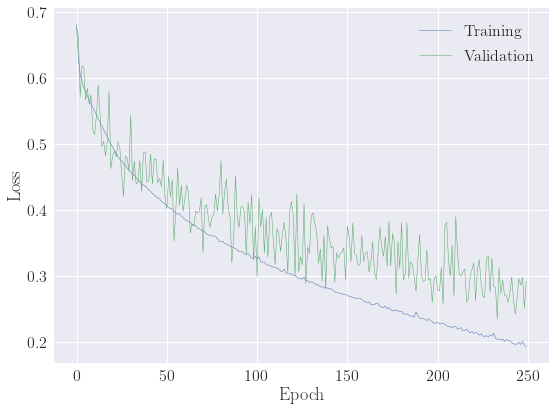

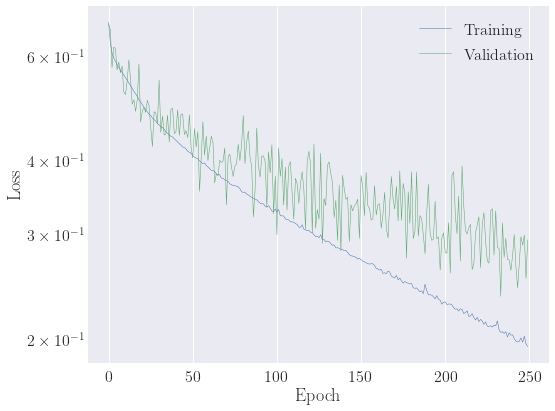

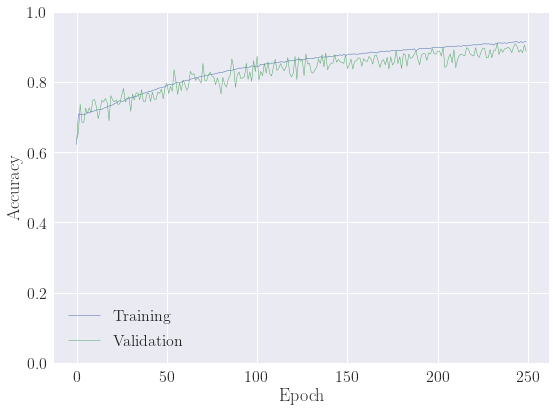

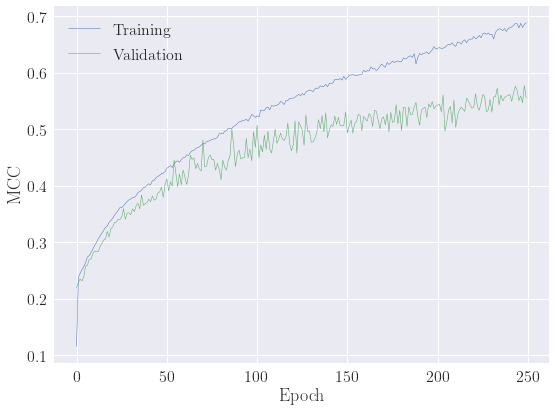

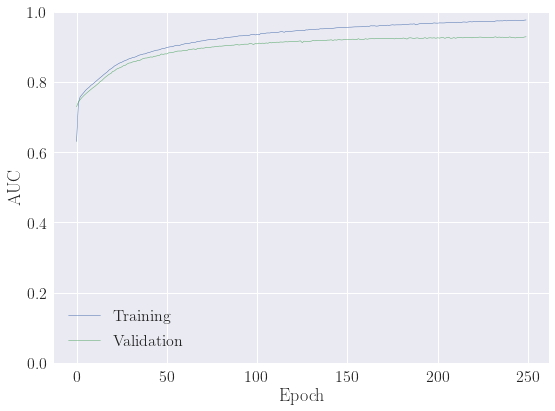

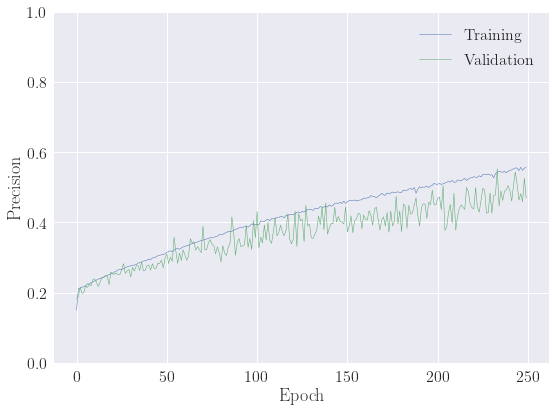

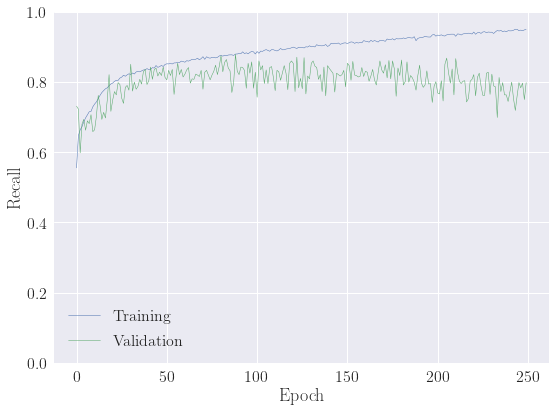

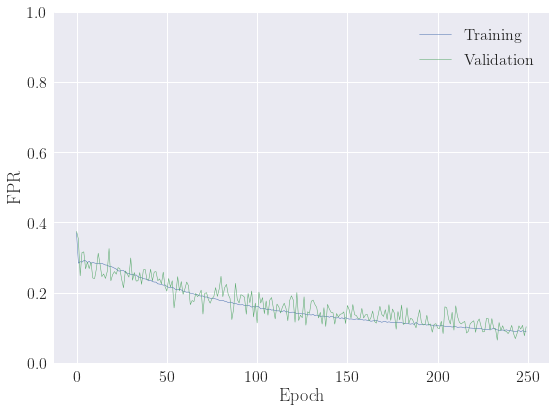

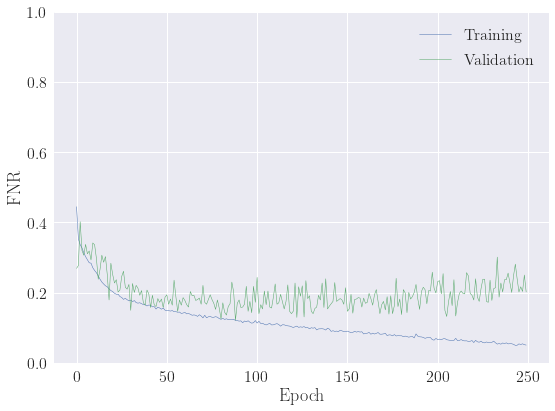

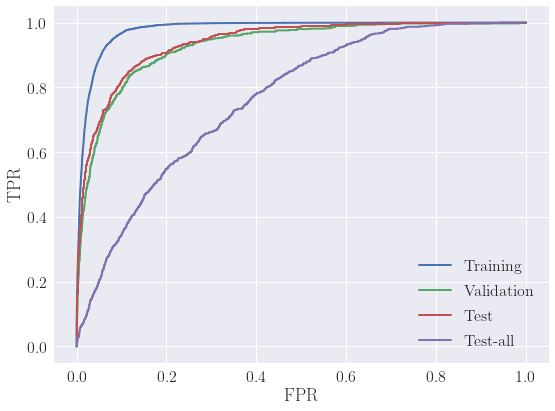

In [9]:
cap.show()

with open(os.path.join(model_dir, "log.txt"), "a") as f:
    f.write(cap.stdout)

In [10]:
import matplotlib.pyplot as plt

from bclassification.utils_fcn import create_dataset

def plot_preds(t, y, y_pred, rhos, threshold, chronic_idx=None):
    fig, ax = plt.subplots(figsize=(Const.FIG_SIZE[0] * 2, Const.FIG_SIZE[1]))

    indices_pos = np.equal(y, 1)
    # ax.plot(t, y, label=r"$y$", color="tab:blue")
    ax.bar(t[indices_pos], y[indices_pos], label=r"$y$", color="tab:blue", lw=1.5)

    # ax.plot(t, y_pred, label=r"$P(y = 1)$", color="tab:green")
    indices_pos = np.greater(y_pred, threshold)
    pos = np.ma.masked_where(np.greater_equal(y_pred, threshold), y_pred)
    neg = np.ma.masked_where(np.less_equal(y_pred, threshold), y_pred)
    ax.plot(t, pos, "tab:green", t, neg, "tab:red")

    ax.plot(t, np.ones_like(t) * threshold, label=r"$y$", color="tab:red")
    # ax.plot(t, rhos, label=r"$y$")

    # ax.legend()
    ax.set_xlabel("Time step t")
    ax.set_ylabel(r"$P(y = 1)$")

    if ax.get_xlim()[-1] > 2000:
        ax.set_xlim(right=2000, left=-10)
    else:
        ax.set_xlim(left=-10)

    fig.tight_layout()
    if model_dir and not isinstance(chronic_idx, type(None)):
        fig.savefig(os.path.join(model_dir, "test-y-step-{:04}".format(chronic_idx)))
        
    if not isinstance(rhos, type(None)):
        ax2 = ax.twinx()
        ax2.set_ylabel(r"$\rho^\mathrm{max}$")
        ax2.plot(t, rhos, label=r"$y$", lw=Const.LW, color="tab:orange")
        ax2.set_ylim(*ax.get_ylim())

    fig.tight_layout()
    if model_dir and not isinstance(chronic_idx, type(None)):
        fig.savefig(os.path.join(model_dir, "test-y-step-{:04}-rhos".format(chronic_idx)))


sample_experience_dir = make_dir(os.path.join(Const.EXPERIENCE_DIR, "data-aug-sample"))
case, collector = load_experience(case_name, agent_name, sample_experience_dir, env_dc=env_dc)

_, _, _, X_all_sample, Y_all_sample = create_dataset(
    case,
    collector,
    input_mode=input_mode,
    label_mode=label_mode,
    n_window_history=n_window_history,
    n_window_targets=n_window_targets,
    downsampling_rate=downsampling_rate,
    n_window_forecasts=n_window_forecasts,
    use_actions=use_actions,
    feature_scaling=feature_scaling,
)


L2RPN_2019_ART (dc)


--------------------------------------------------------------------------------
                                        Loading Experience
--------------------------------------------------------------------------------
    - Loading chronics:                 ./experience/data-aug-sample/l2rpn_2019_art-dc/agent-mip-chronic-****
    - Number of loaded chronics:        7
    - Input structure:                  structured
    - Label structure:                  dn
    - Labels:                           416/38400	1.08 %


6912 6912

    - Dataset                          Chronic 0
        - Loss:                         0.2823
        - TP:                           28/33             84.85 %
        - FP:                           856/6879          12.44 %
        - TN:                           6023/6879         87.56 %
        - FN:                           5/33              15.15 %
        - Accuracy:                     0.8754
        - Mcc:                          0.1494
200 8064

    - Dataset                          Chronic 1
        - Loss:                         0.6248
        - TP:                           5/5              100.00 %
        - FP:                           22/195            11.28 %
        - TN:                           173/195           88.72 %
        - FN:                           0/5                0.00 %
        - Accuracy:                     0.8900
        - Mcc:                          0.4053
8064 8064

    - Dataset                          Chronic 2
        - L

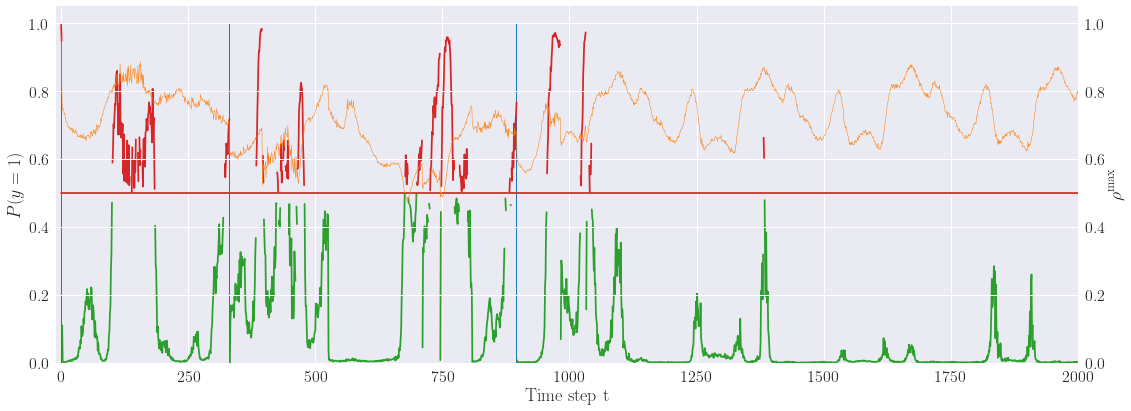

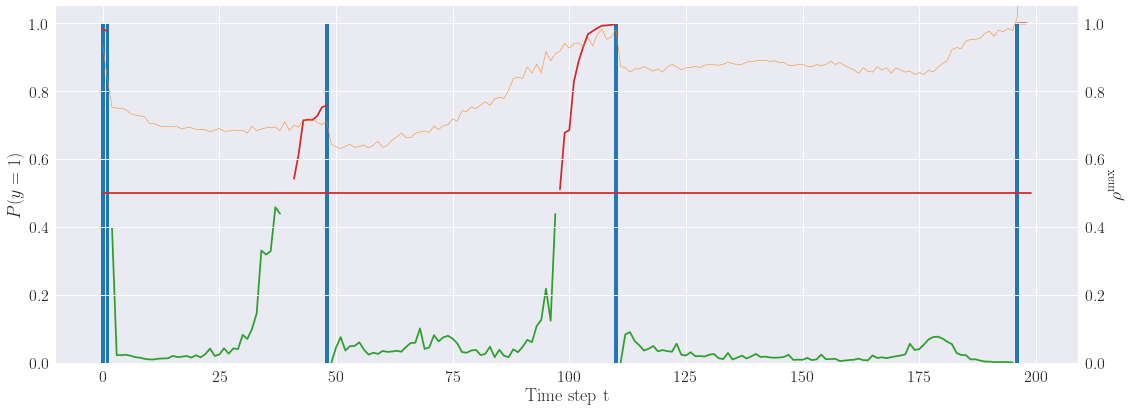

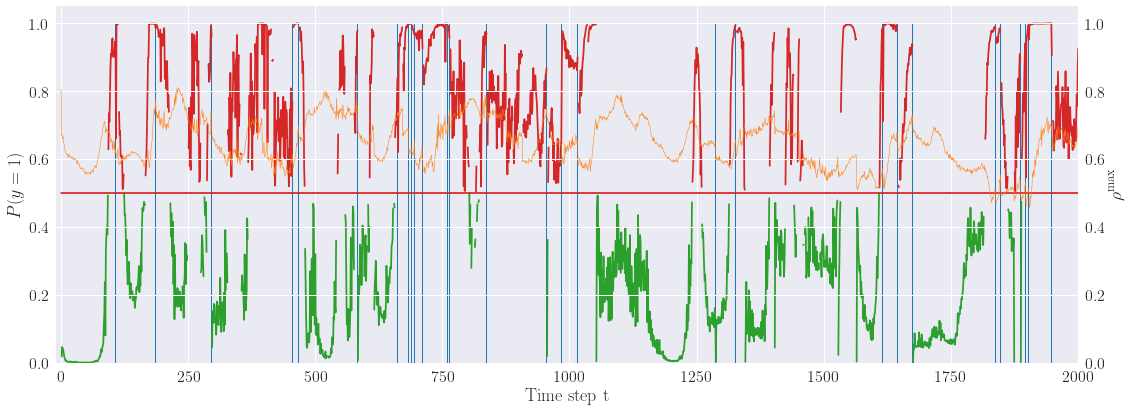

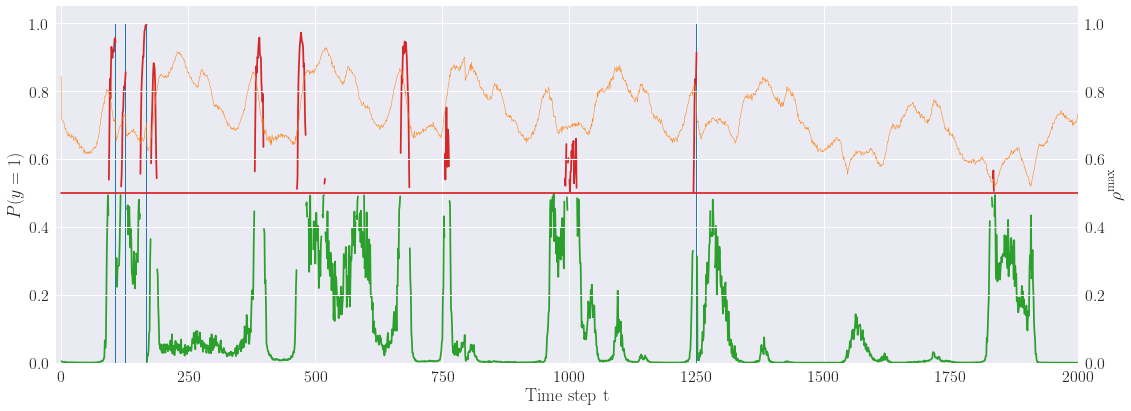

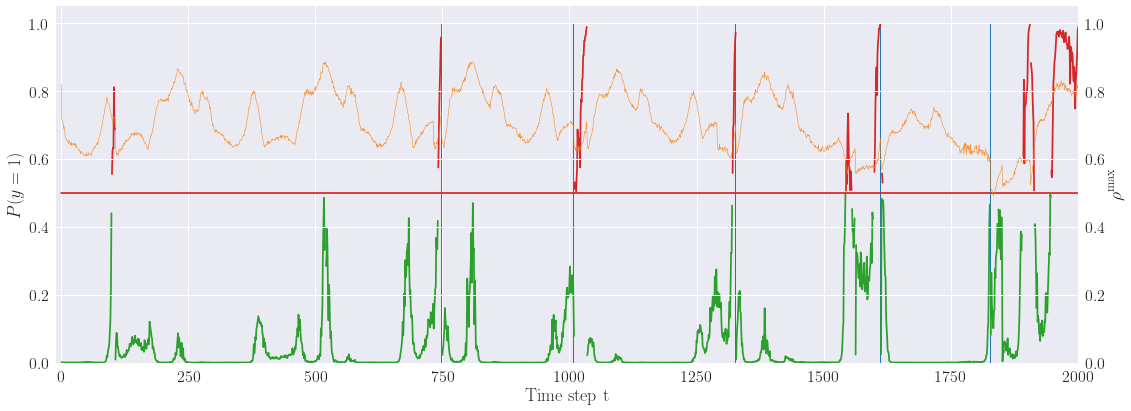

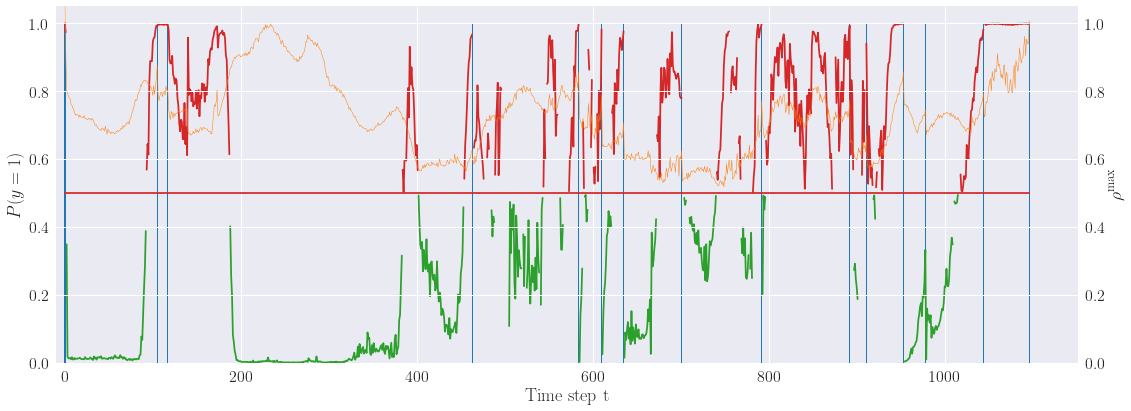

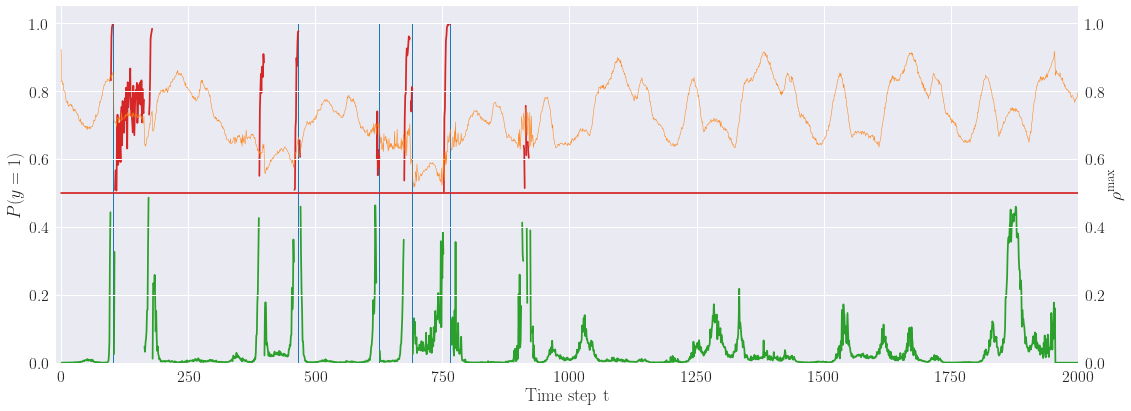

In [13]:
start_idx = 0
for chronic_idx, chronic_len in zip(collector.chronic_ids, collector.chronic_lengths):
    print(collector.data[chronic_idx]["duration"], collector.data[chronic_idx]["chronic_len"])
    
    X_chronic = X_all_sample[start_idx:(start_idx + chronic_len), :]
    Y_chronic = Y_all_sample[start_idx:(start_idx + chronic_len)]
    Y_chronic_pred = model.predict(X_chronic, batch_size=n_batch).flatten()
    
    results_chronic = model.evaluate(X_chronic, Y_chronic, batch_size=n_batch, verbose=0)
    describe_results(model.metrics_names, results_chronic, Y_chronic, name=f"Chronic {chronic_idx}")

    t = np.arange(chronic_len)
    rhos = [np.max(obs.rho) for obs in collector.data[chronic_idx]["obses"][:-1]]
        
    plot_preds(t, Y_chronic, Y_chronic_pred, rhos, threshold, chronic_idx)
    
    start_idx = start_idx + chronic_len

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

def plot_scatter(ax, data, color_label, marker_label=None, x_label=None, y_label=None, ax_title=None):
    colors = Const.COLORS
    
    color_values = sorted(data[color_label].unique())
    
    for i, color_val in enumerate(color_values):
        color_id = i % len(colors)
        color = colors[color_id]
        
        if marker_label:
            marker_values = sorted(data[marker_label].unique())
            for j, marker_val in enumerate(marker_values):
                d = data[np.logical_and(data[color_label] == color_val, data[marker_label] == marker_val)]

                if d.shape[0] > 0:
                    if marker_val == "1":
                        ax.scatter(d[x_label], d[y_label], label=str(color_val), s=50, marker="+", facecolors='none', c=color)
                    elif marker_val == "0":
                        ax.scatter(d[x_label], d[y_label], label=str(color_val), s=30, marker="o", facecolors='none', edgecolors=color, alpha=0.5)
                    else:
                        ax.scatter(d[x_label], d[y_label], label=str(color_val), s=30, marker="+", c=color)                
        else:
            d = data[data[color_label] == color_val]
            ax.scatter(d[x_label], d[y_label], label=str(color_val), s=30, marker="+", c=color)
            
    if len(color_values) < 4 and not marker_label:
        ax.legend(color_values)
        
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if ax_title:
        ax.set_title(ax_title)

"""
    TSNE

    Following: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
"""

file_name = f"tsne-d{dr_str}-h{h_str}-f{f_str}-{tar_str}-{input_mode}.npz"
file_path = os.path.join(experience_dir, file_name)


if file_name in os.listdir(experience_dir):
    pprint("Loading:", file_path)
    tsne_results = np.load(file_path)["tsne_results"]
else:
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
    red = PCA(n_components=100, random_state=random_seed)

    X_red = red.fit_transform(X)
    pprint("    - Explained variance:", red.explained_variance_ratio_.sum())
    tsne_results = tsne.fit_transform(X_red)
    np.savez_compressed(
        file_path,
        tsne_results=tsne_results,
    )
    pprint("Saving:", file_path)

data = pd.DataFrame()
data["tsne-1"] = tsne_results[:, 0]
data["tsne-2"] = tsne_results[:, 1]
data["y"] = Y.astype(int).astype(str)

# data_train, data_val = train_test_split(
#     data, test_size=val_frac, random_state=random_seed
# )

# data_train, data_test = train_test_split(
#     data_train, test_size=test_frac, random_state=random_seed
# )

# fig_name = "tsne-X-train"
# fig, ax = plt.subplots(figsize=Const.FIG_SIZE)
# plot_scatter(ax, data_train, color_label="y", x_label="tsne-1", y_label="tsne-2")
# fig.savefig(os.path.join(model_dir, fig_name))

# fig_name = "tsne-X-val"
# fig, ax = plt.subplots(figsize=Const.FIG_SIZE)
# plot_scatter(ax, data_val, color_label="y", x_label="tsne-1", y_label="tsne-2")
# fig.savefig(os.path.join(model_dir, fig_name))

# fig_name = "tsne-X-test"
# fig, ax = plt.subplots(figsize=Const.FIG_SIZE)
# plot_scatter(ax, data_test, color_label="y", x_label="tsne-1", y_label="tsne-2")
# fig.savefig(os.path.join(model_dir, fig_name))

In [ ]:
Y_pred = np.greater(model.predict(X, batch_size=n_batch), threshold).astype(int).flatten()
data["y"][np.logical_and(np.not_equal(Y, Y_pred), np.equal(Y, 1))] = "2"

data_train, data_val = train_test_split(
    data, test_size=val_frac, random_state=random_seed
)

data_train, data_test = train_test_split(
    data_train, test_size=test_frac, random_state=random_seed
)

fig_name = "tsne-X-train"
fig, ax = plt.subplots(figsize=Const.FIG_SIZE)
plot_scatter(ax, data_train, color_label="y", x_label="tsne-1", y_label="tsne-2")
fig.savefig(os.path.join(model_dir, fig_name))

fig_name = "tsne-X-labels-val"
fig, ax = plt.subplots(figsize=Const.FIG_SIZE)
plot_scatter(ax, data_val, color_label="y", x_label="tsne-1", y_label="tsne-2")
fig.savefig(os.path.join(model_dir, fig_name))

fig_name = "tsne-X-labels-test"
fig, ax = plt.subplots(figsize=Const.FIG_SIZE)
plot_scatter(ax, data_test, color_label="y", x_label="tsne-1", y_label="tsne-2")
fig.savefig(os.path.join(model_dir, fig_name))

In [ ]:
data = pd.DataFrame()
data["tsne-1"] = tsne_results[:, 0]
data["tsne-2"] = tsne_results[:, 1]
data["y"] = Y.astype(int).astype(str)

Y_pred = np.greater(model.predict(X, batch_size=n_batch), threshold).astype(int).flatten()
data["y"][np.logical_and(np.not_equal(Y, Y_pred), np.equal(Y, 1))] = "2"

data_train, data_val = train_test_split(
    data, test_size=val_frac, random_state=random_seed
)

data_train, data_test = train_test_split(
    data_train, test_size=test_frac, random_state=random_seed
)

   
fig, ax = plt.subplots(figsize=Const.FIG_SIZE)
for y, label in [("0", "N"), ("1", "TP"), ("2", "FN")]:
    d = data_test[data_test["y"] == y]
    ax.scatter(d["tsne-1"], d["tsne-2"], label=label, s=30, marker="x", linewidths=1)
ax.legend()
fig.savefig(os.path.join(model_dir, "tsne-test-fn"))

data["y"] = Y.astype(int).astype(str)
Y_pred = np.greater(model.predict(X, batch_size=n_batch), threshold).astype(int).flatten()
data["y"][np.logical_and(np.not_equal(Y, Y_pred), np.equal(Y, 0))] = "2"

data_train, data_val = train_test_split(
    data, test_size=val_frac, random_state=random_seed
)

data_train, data_test = train_test_split(
    data_train, test_size=test_frac, random_state=random_seed
)

fig, ax = plt.subplots(figsize=Const.FIG_SIZE)
for y, label in [("0", "TN"), ("1", "P"), ("2", "FP")]:
    d = data_test[data_test["y"] == y]
    ax.scatter(d["tsne-1"], d["tsne-2"], label=label, s=30, marker="x", linewidths=1)
ax.legend()
fig.savefig(os.path.join(model_dir, "tsne-test-fp"))